<div style="text-align: center;">
  <h3>Time Series Analysis</h3>
  <h5>Formative Assessment 2</h5>
  <h5><u>By Romand Lansangan</u></h5>
</div>

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Advertising and Sales.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Store                 10 non-null     int64
 1   TV Ad ($k)            10 non-null     int64
 2   Radio Ad ($k)         10 non-null     int64
 3   Social Media Ad ($k)  10 non-null     int64
 4   Discounts (%)         10 non-null     int64
 5   Sales ($k)            10 non-null     int64
dtypes: int64(6)
memory usage: 612.0 bytes
None


,Store,TV Ad ($k),Radio Ad ($k),Social Media Ad ($k),Discounts (%),Sales ($k)
0,1,230,37,22,5,650
1,2,44,39,10,7,270
2,3,17,45,12,10,180
3,4,151,41,24,6,500
4,5,180,10,15,8,525


In [4]:
import statsmodels.api as sm

response = 'Sales ($k)' 
Y = df[response]
X = df.drop(columns=response)
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Sales ($k)   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     73.73
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           0.000499
Time:                        16:52:56   Log-Likelihood:                -43.142
No. Observations:                  10   AIC:                             98.28
Df Residuals:                       4   BIC:                             100.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  297.9210 

Multiple linear regression with all the variables (except "Sales") included:

$$
\text{Sales}_{(k)} \;=\; \\ 297.921 \\
\;-\; 3.758 \cdot \text{Store} \\
\;+\; 1.7255 \cdot \text{TV Ad (\$k)} \\ 
\;-\; 0.7295 \cdot \text{Radio Ad(\$k)} \\ 
\;+\; 3.3007 \cdot \text{Social Media Ad(\$k)} \\
\;-\; 14.9212 \cdot \text{Discounts (\%)} 
$$

Although the Adj R-Sq is excellent, this will not do for the final model since most of the p-values of coeficients are not significant. For this reason, a stepwise selection is imperative.

#### Stepwise Selection

In [5]:
def forward_selection(df, response, model=None, enter_threshold=0.05):
    all_cols = df.drop(columns=response).columns

    if model is not None:
        selected_cols = [c for c in model.params.index if c != "const"]
    else:
        selected_cols = []

    all_cols_not_selected = set(all_cols) - set(selected_cols)

    model_select = model
    col_added = None
    best_sse_reduction = 0.0

    # baseline SSE (if no model yet, use total variance)
    if model is not None:
        baseline_sse = sum(model.resid ** 2)
    else:
        baseline_sse = sum((df[response] - df[response].mean()) ** 2)

    for col in all_cols_not_selected:
        cols_to_train = selected_cols + [col]
        X = sm.add_constant(df[cols_to_train], has_constant="add")
        y = df[response]

        model_current = sm.OLS(y, X).fit()
        sse_current = sum(model_current.resid ** 2)
        sse_reduction = baseline_sse - sse_current

        pval = model_current.pvalues[col]

        if pval < enter_threshold and sse_reduction > best_sse_reduction:
            model_select = model_current
            col_added = col
            best_sse_reduction = sse_reduction

    if col_added is None:
        print("None was selected")
        return None
    else:
        print(f"`{col_added}` was selected (p < {enter_threshold}, SSE reduction = {best_sse_reduction:.2f})")
        return model_select


def backward_selection(df, model, exit_threshold=0.10):
    response = model.model.endog_names
    selected_cols = [c for c in model.params.index if c != "const"]

    baseline_sse = sum(model.resid ** 2)

    model_select = model
    col_removed = None
    min_sse_increase = np.inf

    for col in selected_cols:
        cols_to_train = list(set(selected_cols) - {col})
        X = sm.add_constant(df[cols_to_train], has_constant="add")
        y = df[response]

        model_current = sm.OLS(y, X).fit()
        sse_current = sum(model_current.resid ** 2)
        sse_increase = sse_current - baseline_sse

        pval = model.pvalues[col]

        if pval > exit_threshold and sse_increase < min_sse_increase:
            model_select = model_current
            col_removed = col
            min_sse_increase = sse_increase

    if col_removed is None:
        print("None was removed")
        return None
    else:
        print(f"`{col_removed}` was removed (p > {exit_threshold}, SSE increase = {min_sse_increase:.2f})")
        return model_select



def stepwise_selection(df, response, enter_threshold=0.05, exit_threshold=0.10):
    print("Creating Initial Model")
    model = forward_selection(df, response, enter_threshold=enter_threshold)

    if model is None:
        print("No variables entered. Empty model.")
        return None

    while True:
        model_changed = False

        # Forward step
        print("Running Forward Selection")
        new_model = forward_selection(df, response, model=model, enter_threshold=enter_threshold)
        if new_model is not None:
            model = new_model
            model_changed = True

        # Backward step
        print("Running Backward Selection")
        new_model = backward_selection(df, model, exit_threshold=exit_threshold)
        if new_model is not None:
            model = new_model
            model_changed = True

        # Stop if no change in this cycle
        if not model_changed:
            break

    return model


Basically what this function does is for every stage, it picks the best variable that reduces the Sum of Squares (SSE) the most and meets a certain threshold of p-value. 

In [6]:
model = stepwise_selection(df, response='Sales ($k)')
model.summary()

Creating Initial Model
`TV Ad ($k)` was selected (p < 0.05, SSE reduction = 295189.75)
Running Forward Selection
`Discounts (%)` was selected (p < 0.05, SSE reduction = 4863.48)
Running Backward Selection
None was removed
Running Forward Selection
None was selected
Running Backward Selection
None was removed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sales ($k)   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     218.8
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           4.90e-07
Time:                        16:52:56   Log-Likelihood:                -45.058
No. Observations:                  10   AIC:                             96.12
Df Residuals:                       7   BIC:                             97.02
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           276.0688     55.267      4.995      0.002     145.384     406.754
TV Ad ($k)        1.9469      0.173     11.266      0.000       1.538       2.356
Discounts (%)   -14.3261      5.379     -2.663      0.032     -27.045      -1.607
==============================================================================
Omnibus:                       14.182   Durbin-Watson:                   2.505
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                7.083
Skew:                          -1.775   Prob(JB):                       0.0290
Kurtosis:                       5.098   Cond. No.                         890.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Reduced Model
After Stepwise Selection, the final model will be:

$$
\text{Sales}_{(\$ k)} \;=\; 276.0688 
\;+\; 1.7255 \cdot \text{TV Ad  (\$ k)} 
\;-\; 14.9212 \cdot \text{Discounts (\%)} 
$$


- Intercept (276.0688 ) - does not have a practical application but can be thought of as the value of Sales when there's no spending for `TV Ad` and `Discounts`.
- `Tv Ad` (1.7255) - it means that for every unit (\$k) increase of `Tv Ad`, `Sales` will increase with 1.7255 unit (\$ k). Also, since p-value<0.05, `Tv Ad` significantly affects `Sales`.
- `Discounts` (-14.9212) - it means that for every unit (\%) increase of `Tv Ad`, `Sales` will decrease with 14.9212 unit (\$ k). Also, since p-value>0.05, `Discounts` does not significantly affect `Sales`.


#### Comparing with Total Model
It is clear that the **Reduced Model is simpler and better model than the Total Model** due to:
- Less paramaters - including intercept, the Total Model has 6 parameters. This was reduced to 3 parameters in Reduced Model, making it easier to interpret and understand.
- Overfitting is less likely - with simpler model, the Reduced Model reduce the risk of overfitting compared to a more complex Total Model.
- Better Adj. R-Sq - The Adj. R-Sq of Total Model is about 0.976 while the same metric is about 0.980 in Reduced Model. 

Overall, this comparison sheds light on the idea that a more complex model does not necessarily mean a better preditive power.

### Assumption Checking

In [7]:
sns.set_theme()
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['axes.facecolor'] = 'lightgrey'
plt.rcParams['font.family'] = 'serif'

#### Linearity

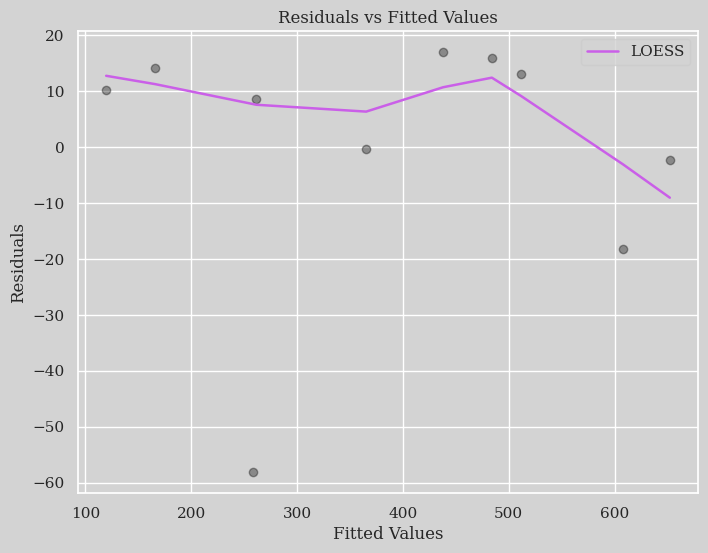

In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))

sns.regplot(x=model.predict(), 
            y=model.resid, 
            scatter_kws={'alpha':0.35, 'color' : "black"}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False)

plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()

plt.show()

The curved shape of the LOESS (purple line) indicates a vilation in linearity since we expect the residuals to be randomly scattered around zero and the LOESS to be relatively flat, but this is not the case in plot. This imply that there's an important non-linear relationship between the predictors and the response that the current linear model is failing to account for. Since the relationship may not be linear, this fact implore us to try out some transformation or add additional term (like polynomial terms) to the model. 

#### Normality of Residuals

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(model.resid.to_frame())
standardized_resid = scaler.transform(model.resid.to_frame()).squeeze()
standardized_resid_sorted = np.sort(standardized_resid)

normal_theo = np.sort(np.random.normal(0, 1, len(standardized_resid)));

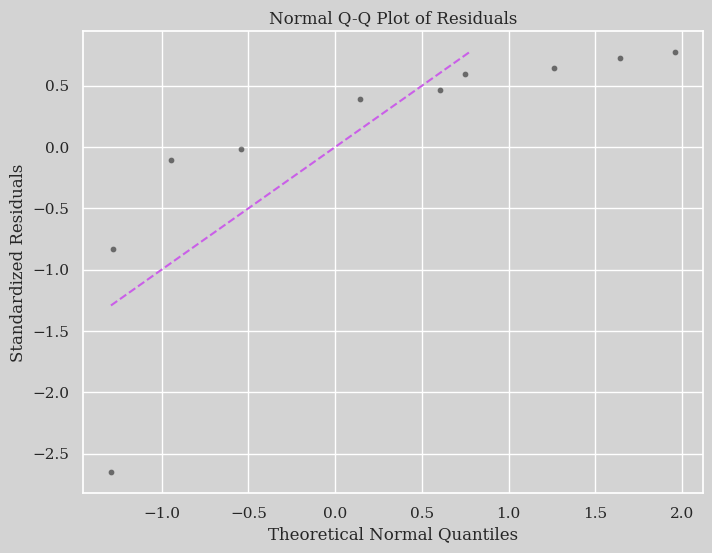

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 6))


sns.scatterplot(x=normal_theo,
                y=standardized_resid_sorted,
                color="black",
                ax=ax,
                alpha=0.5,
                s=20)

line_coords = np.linspace(min(normal_theo), max(standardized_resid_sorted))

ax.plot(line_coords, line_coords, color='#ca5fe8', linestyle="--") 


ax.set_title('Normal Q-Q Plot of Residuals')
ax.set_xlabel('Theoretical Normal Quantiles')
ax.set_ylabel('Standardized Residuals');

Normality of residuals was also violated since the Standardized residuals does not follow the linear line (shaded purple). There's a particular S-Shape pattern however that has formed in the residuals which is an indicator skewness in residuals rather than normal distribution.

Text(0.5, 0.98, 'Standardized Residual Distribution')

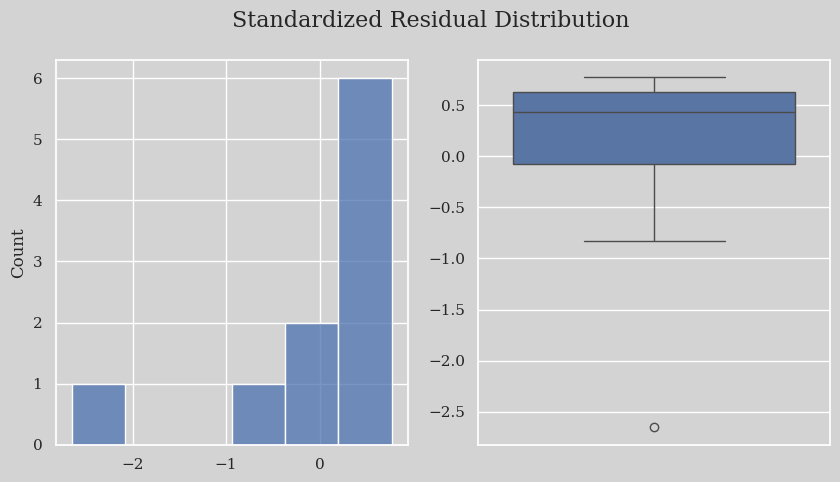

In [11]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

sns.histplot(standardized_resid_sorted, ax=ax[0])
sns.boxplot(y=standardized_resid_sorted, ax=ax[1])
fig.suptitle('Standardized Residual Distribution', fontsize=16)

Both plots consistently suggest that the residuals are negatively skewed and contain at least one outlier on the negative side. This is not characteristic of a normal distribution.

#### Homoscedasticity

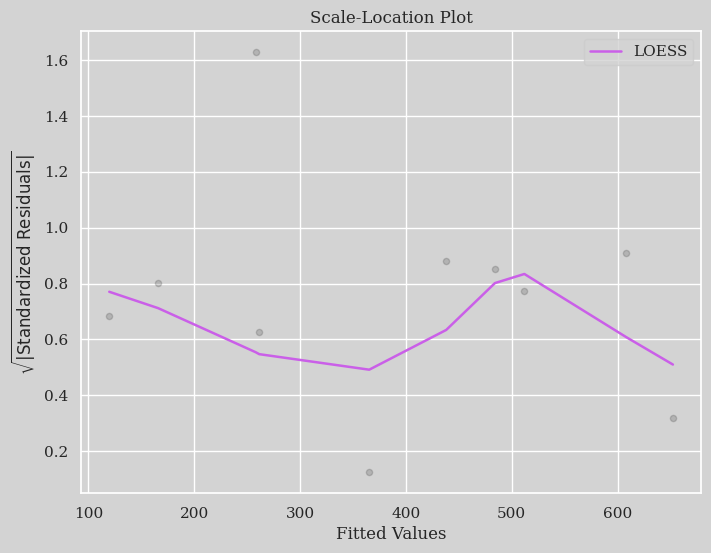

In [12]:
abs_standardized_resid = np.abs(standardized_resid)
sqrt_abs_standardized_resid = np.sqrt(abs_standardized_resid)

fig, ax = plt.subplots(ncols=1, figsize=(8, 6))
sns.regplot(x=model.predict(),
            y=sqrt_abs_standardized_resid,
            ax=ax,
            scatter_kws={'alpha': 0.15, 'color': 'black', 's': 20}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False    
           )

ax.set_title('Scale-Location Plot')
ax.set_xlabel('Fitted Values') 
ax.set_ylabel(r'$\sqrt{|\text{Standardized Residuals}|}$')

plt.legend()
plt.show()

LOESS line is clearly not flat! Indicating a violation in Equality in Variance.

#### Indendependence of Observed Values

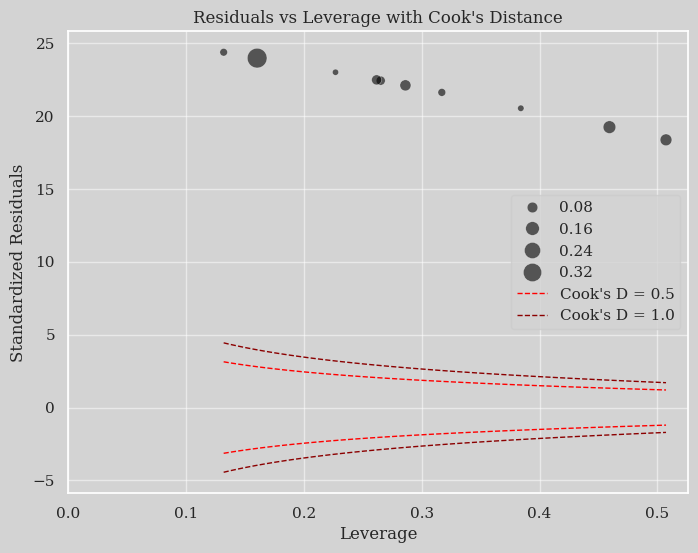

In [13]:
influence = model.get_influence()

standardized_resid = influence.resid_std
leverage_values = influence.hat_matrix_diag
cooks_distance = influence.cooks_distance[0] 


fig, ax = plt.subplots(ncols=1, figsize=(8, 6))

sns.scatterplot(x=leverage_values,
                y=standardized_resid,
                size=cooks_distance,
                sizes=(20, 200),
                alpha=0.6,
                color='black',
                legend="brief", 
                ax=ax)


num_params = model.df_model + 1

leverage_plot = np.linspace(leverage_values.min(), leverage_values.max(), 100)
leverage_plot = leverage_plot[(leverage_plot > 0) & (leverage_plot < 1)]

def cooks_threshold_y(cooks_d, leverage, num_params):
    h_ii_safe = leverage + np.finfo(float).eps # to avoid division by 0

    one_minus_h_ii_safe = (1 - leverage) + np.finfo(float).eps
    
    numerator = cooks_d * num_params * one_minus_h_ii_safe
    denominator = h_ii_safe
    
    y_squared = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator!=0)
    y_squared[y_squared < 0] = 0 

    return np.sqrt(y_squared)

cooks_d_threshold1 = 0.5
cooks_d_threshold2 = 1.0

y_threshold1 = cooks_threshold_y(cooks_d_threshold1, leverage_plot, num_params)
y_threshold2 = cooks_threshold_y(cooks_d_threshold2, leverage_plot, num_params)

ax.plot(leverage_plot, y_threshold1, label=f"Cook's D = {cooks_d_threshold1}", color='red', linestyle='--', lw=1)
ax.plot(leverage_plot, -y_threshold1, color='red', linestyle='--', lw=1)
ax.plot(leverage_plot, y_threshold2, label=f"Cook's D = {cooks_d_threshold2}", color='darkred', linestyle='--', lw=1)
ax.plot(leverage_plot, -y_threshold2, color='darkred', linestyle='--', lw=1) 


ax.set_title("Residuals vs Leverage with Cook's Distance") 
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Leverage')
ax.set_xlim(left=0)

ax.legend()

plt.grid(True, linestyle='-', alpha=0.5)
plt.show()

All the assumptions are violated. This is therefore not a very good linear model since it may result to

1. Introducing new terms (like polynomial terms) - maybe the relationship isn't linear at all.
2. Transform variables - the model may not be as vindictive to other space.
3. Apply either, GLS or WLS to address for unequal of variance.


Since all assumptions are violated, adding to the fact that sample size is sparse with n=10, this linear model although have a high Adj. R-Sq = 0.98, isn't a reliable model. 

---

##  Monthly Sales and Advertising

In [14]:
df2 = pd.read_csv("Monthly Sales and Ad.csv")
print(df2.info())
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Month       12 non-null     int64
 1   TV_Ad ($k)  12 non-null     int64
 2   Sales ($k)  12 non-null     int64
dtypes: int64(3)
memory usage: 420.0 bytes
None


,Month,TV_Ad ($k),Sales ($k)
0,1,230,650
1,2,44,265
2,3,17,175
3,4,151,490
4,5,180,525


In [38]:
response = 'Sales ($k)' 
Y = df2[response]
X = df2.drop(columns=response)
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sales ($k)   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     135.9
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           1.89e-07
Time:                        17:45:50   Log-Likelihood:                -57.590
No. Observations:                  12   AIC:                             121.2
Df Residuals:                       9   BIC:                             122.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.7580     25.767      4.454      0.002      56.468     173.048
Month          3.4347      2.839      1.210      0.257      -2.989       9.858
TV_Ad ($k)     2.3200      0.142     16.375      0.000       1.999       2.640
==============================================================================
Omnibus:                        3.911   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                1.538
Skew:                          -0.844   Prob(JB):                        0.463
Kurtosis:                       3.478   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='Month', ylabel='Sales ($k)'>

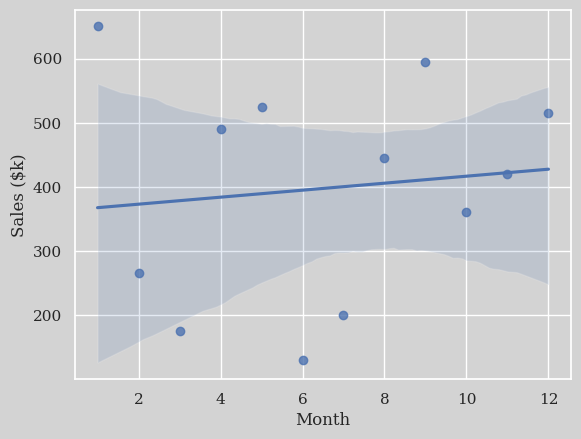

In [15]:
sns.regplot(x=df2['Month'], y=df2['Sales ($k)'])

In [22]:
from statsmodels.stats.stattools import durbin_watson
Y = df2[response]
X = df2['Month']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

residuals = model.resid

dw_statistic = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_statistic}")

Durbin-Watson statistic: 1.786887582398005


According to the [reference](https://www3.nd.edu/~wevans1/econ30331/durbin_watson_tables.pdf
), the dL and dU for a Durbin-Watson statistic with n=10 and k=1 are:
- dL = 0.604
- dU = 1.001

$H_0$ : No autocorrelations

Decision:

Since $DW \approx 1.79 > 1.001 \approx dU$, we fail to reject the null-hypothesis ($H_0$). Therefore, there exist no autocorrelations. Although it is wise to take this result with a grain of salt since Durbin-Watson have small sample bias [Spencer, 1975](https://www.sciencedirect.com/science/article/abs/pii/0304407675900342).

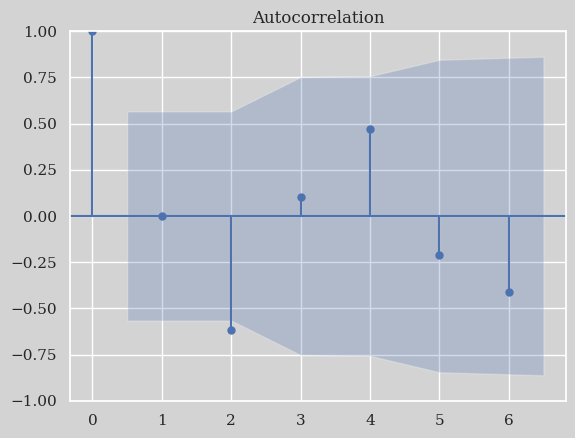

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df2[response]);

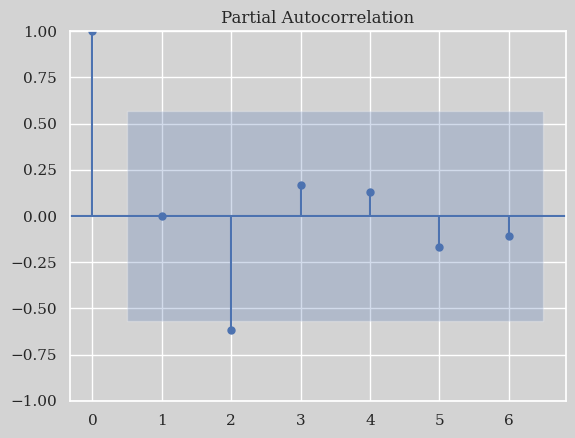

In [20]:
plot_pacf(df2[response]);

---

### Part 3: Sales with Heteroscedasticity

In [ ]:
df3 = pd.read_csv("Sales Hetero.csv")
print(df3.info())
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Store             10 non-null     int64
 1   Advertising ($k)  10 non-null     int64
 2   Sales ($k)        10 non-null     int64
dtypes: int64(3)
memory usage: 372.0 bytes
None


,Store,Advertising ($k),Sales ($k)
0,1,230,650
1,2,44,270
2,3,17,185
3,4,151,500
4,5,180,520


In [27]:
response = "Sales ($k)"
predictor = "Advertising ($k)"
Y = df3[response]
X = df3[predictor]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sales ($k)   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     237.1
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           3.14e-07
Time:                        17:07:49   Log-Likelihood:                -48.786
No. Observations:                  10   AIC:                             101.6
Df Residuals:                       8   BIC:                             102.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              130.7056     19.980      6.542      0.000      84.632     176.779
Advertising ($k)     2.3181      0.151     15.398      0.000       1.971       2.665
==============================================================================
Omnibus:                        1.608   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.448   Jarque-Bera (JB):                0.793
Skew:                          -0.668   Prob(JB):                        0.673
Kurtosis:                       2.659   Cond. No.                         236.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

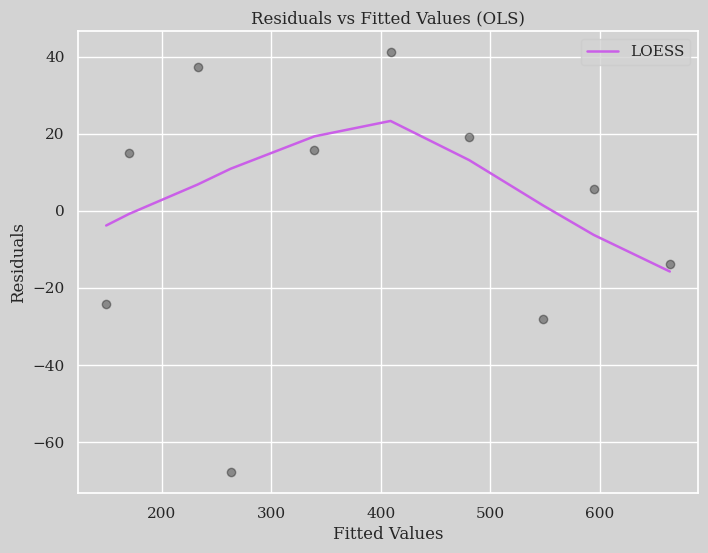

In [37]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))

sns.regplot(x=model.predict(), 
            y=model.resid, 
            scatter_kws={'alpha':0.35, 'color' : "black"}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False)

plt.title('Residuals vs Fitted Values (OLS)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()

plt.show()

Ideally speaking, we want the LOESS line to be a relatively flat line hovering around 0. However, the LOESS line shown above was more of a curve than a flat line. This might indicate a missing nonlinear terms. Since the curve isn't the ideal, we can confidently assert that Equality in Variance of OLS was violated.


Now, before proceeding, let's check if autocorrelation exist using DW test.

In [29]:
from statsmodels.stats.stattools import durbin_watson
residuals = model.resid

dw_statistic = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_statistic}")

Durbin-Watson statistic: 2.0275032545294804


According to Durbin-Watson statistics, since $DW \approx 2.03$ autocorrelation does not exists. Thus, Weighted Least Squares (WLS) is best for correcting heteroscedasticity.

In [31]:
response = "Sales ($k)"
predictor = "Advertising ($k)"
Y = df3[response]
X = df3[predictor]
X = sm.add_constant(X)
model_ols = sm.OLS(Y, X).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sales ($k)   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     237.1
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           3.14e-07
Time:                        17:28:30   Log-Likelihood:                -48.786
No. Observations:                  10   AIC:                             101.6
Df Residuals:                       8   BIC:                             102.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              130.7056     19.980      6.542      0.000      84.632     176.779
Advertising ($k)     2.3181      0.151     15.398      0.000       1.971       2.665
==============================================================================
Omnibus:                        1.608   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.448   Jarque-Bera (JB):                0.793
Skew:                          -0.668   Prob(JB):                        0.673
Kurtosis:                       2.659   Cond. No.                         236.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
weights = 1 / (X[predictor] ** 2)

# Fit WLS
model_wls = sm.WLS(Y, X, weights=weights).fit()
model_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             Sales ($k)   R-squared:                       0.879
Model:                            WLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     58.21
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           6.13e-05
Time:                        17:29:24   Log-Likelihood:                -54.878
No. Observations:                  10   AIC:                             113.8
Df Residuals:                       8   BIC:                             114.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              110.2235      7.744     14.233      0.000      92.365     128.082
Advertising ($k)     2.6569      0.348      7.629      0.000       1.854       3.460
==============================================================================
Omnibus:                        2.875   Durbin-Watson:                   1.260
Prob(Omnibus):                  0.238   Jarque-Bera (JB):                1.049
Skew:                           0.792   Prob(JB):                        0.592
Kurtosis:                       3.103   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
params_ols = model_ols.params
params_ols.rename("OLS", inplace=True)

params_wls = model_wls.params
params_wls.rename("WLS", inplace=True)


coefs = pd.concat([params_ols, params_wls], axis=1)

coefs

,OLS,WLS
const,130.705562,110.223486
Advertising ($k),2.318090,2.656906


In [60]:
ssr = pd.Series({
    "OLS" : model_ols.ssr,
    "WLS" : model_wls.ssr
})

pd.concat([coefs, ssr], axis=1)

,OLS,WLS,0
const,130.705562,110.223486,NaN
Advertising ($k),2.318090,2.656906,NaN
OLS,NaN,NaN,10116.689816
WLS,NaN,NaN,6.331004


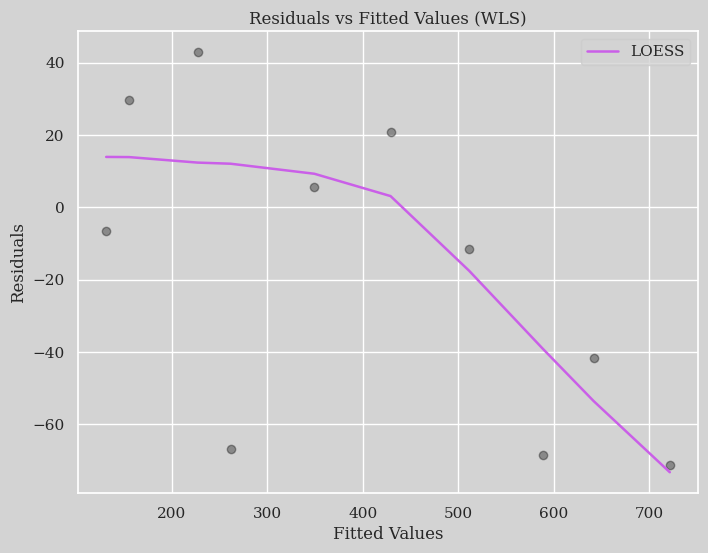

In [36]:
plt.figure(figsize=(8, 6))

sns.regplot(x=model_wls.predict(), 
            y=model_wls.resid, 
            scatter_kws={'alpha':0.35, 'color' : "black"}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False)

plt.title('Residuals vs Fitted Values (WLS)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()

plt.show()